In [15]:
"""
Links
  https://github.com/gautham20/pytorch-ts/blob/master/item%20sales%20forecasting.ipynb
  https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60
  
"""
!pip install plotly_express
!pip install torchcontrib

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7533 sha256=55165f822fb77c8e0cddd9031ac3cd6364e49ea55d0ce74b74d59acfff09b687
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
Successfully built torchcontrib


In [3]:
%load_ext autoreload
%autoreload 2

# Libraries and general settings
from google.colab import drive
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly_express as px
from tqdm.notebook import tqdm
import warnings

# ML related
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import acf, pacf
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchcontrib

from ts_models.encoders import RNNEncoder, RNNConcatEncoder, RNNInitEncoder
from ts_models.decoders import DecoderCell, AttentionDecoderCell
from ts_models.encoder_decoder import EncoderDecoderWrapper
from ts_models.encoder_decoder_attention import EncoderDecoderAttentionWrapper

from torch_utils.cocob import COCOBBackprop
from torch_utils.trainer import TorchTrainer

torch.manual_seed(420)
np.random.seed(420)


matplotlib.rcParams["figure.figsize"] = (12.0, 12.0)
pd.set_option("precision", 4)
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)
warnings.filterwarnings("ignore")
tqdm.pandas()  # Add progress bar to pandas work

drive.mount("/content/gdrive")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("%d GPU(s) available, namely %s" % (torch.cuda.device_count(), torch.cuda.get_device_name(0)))
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")


DATA_FOLDER = "/content/gdrive/My Drive/xheng/data/demand-forecasting"


mode = "test"  # 'valid', "test"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
1 GPU(s) available, namely Tesla K80


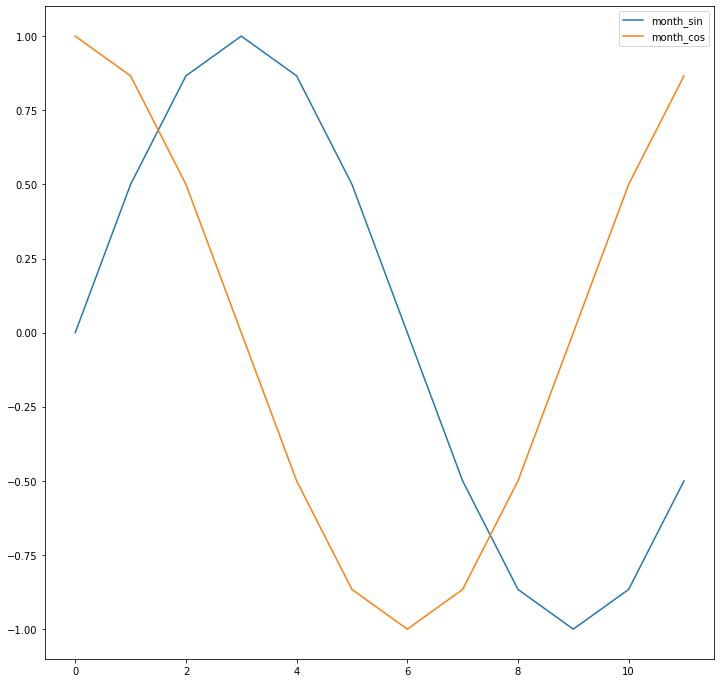

In [4]:
def sin_transform(values):
    return np.sin(2 * np.pi * values / len(set(values)))


def cos_transform(values):
    return np.cos(2 * np.pi * values / len(set(values)))


def get_yearly_autocorr(data):
    """Get yearly autocorrelation for each time series"""
    ac = acf(data, nlags=366)
    return (0.5 * ac[365]) + (0.25 * ac[364]) + (0.25 * ac[366])


def save_scale_map(name, scale_map):
    with open(name + ".pickle", "wb") as handle:
        pickle.dump(scale_map, handle, protocol=pickle.HIGHEST_PROTOCOL)


plt.plot(sin_transform(np.arange(0, 12)), label="month_sin")
plt.plot(cos_transform(np.arange(0, 12)), label="month_cos")
plt.legend()

In [5]:
# @title Default title text
def reduce_mem_usage(df, verbose: int = 1):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose >= 1:
        print(
            "Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
# Load the raw train and test data
train = pd.read_csv("%s/train.csv" % DATA_FOLDER)
test = pd.read_csv("%s/test.csv" % DATA_FOLDER)

train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

In [7]:
print("\ntrain.describe():\n", train.describe())
print("\ntrain.head():\n", train.head())
print("\n################################")

print("\ntest.describe():\n", test.describe())
print("\ntest.head():\n", test.head())

print("\nmin and max of train's date range:", train["date"].min(), train["date"].max())
print("\nmin and max of test's date range:", test["date"].min(), test["date"].max())


train.describe():
              store         item        sales
count  913000.0000  913000.0000  913000.0000
mean        5.5000      25.5000      52.2503
std         2.8723      14.4309      28.8011
min         1.0000       1.0000       0.0000
25%         3.0000      13.0000      30.0000
50%         5.5000      25.5000      47.0000
75%         8.0000      38.0000      70.0000
max        10.0000      50.0000     231.0000

train.head():
         date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

################################

test.describe():
                id       store       item
count  45000.0000  45000.0000  45000.000
mean   22499.5000      5.5000     25.500
std    12990.5254      2.8723     14.431
min        0.0000      1.0000      1.000
25%    11249.7500      3.0000     13.000
50%    22499.5000      5.5000     25.500
75%    33749.2500    

In [8]:
test["sales"] = np.nan  # Add the sales column
data = pd.concat([train, test], ignore_index=True)
data["store_item_id"] = data["store"].astype(str) + "_" + data["item"].astype(str)
data.drop("id", axis=1, inplace=True)
data.sort_values(["store_item_id", "date"], inplace=True)
print("\ndata.decribe():\n", data.describe())
print("\ndata.head():\n", data.head())

# Add data time related features
# They are not considered as look-ahead bias
data["dayofweek"] = data["date"].dt.dayofweek
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year
data["day"] = data["date"].dt.day
data["year_mod"] = (data["year"] - data["year"].min()) / (data["year"].max() - data["year"].min())

# Add sin and cos
data["dayofweek_sin"] = sin_transform(data["dayofweek"])
data["dayofweek_cos"] = cos_transform(data["dayofweek"])
data["month_sin"] = sin_transform(data["month"])
data["month_cos"] = cos_transform(data["month"])
data["day_sin"] = sin_transform(data["day"])
data["day_cos"] = cos_transform(data["day"])


data.decribe():
              store         item        sales
count  958000.0000  958000.0000  913000.0000
mean        5.5000      25.5000      52.2503
std         2.8723      14.4309      28.8011
min         1.0000       1.0000       0.0000
25%         3.0000      13.0000      30.0000
50%         5.5000      25.5000      47.0000
75%         8.0000      38.0000      70.0000
max        10.0000      50.0000     231.0000

data.head():
             date  store  item  sales store_item_id
16434 2013-01-01     10     1   14.0          10_1
16435 2013-01-02     10     1   14.0          10_1
16436 2013-01-03     10     1   16.0          10_1
16437 2013-01-04     10     1   17.0          10_1
16438 2013-01-05     10     1   12.0          10_1




scaled_data.decribe():
              store         item        sales    dayofweek        month  \
count  958000.0000  958000.0000  913000.0000  958000.0000  958000.0000   
mean        5.5000      25.5000      -0.1459       3.0000       6.3111   
std         2.8723      14.4309       1.0075       1.9987       3.5046   
min         1.0000       1.0000      -3.1931       0.0000       1.0000   
25%         3.0000      13.0000      -0.8845       1.0000       3.0000   
50%         5.5000      25.5000      -0.2049       3.0000       6.0000   
75%         8.0000      38.0000       0.5287       5.0000       9.0000   
max        10.0000      50.0000       5.3394       6.0000      12.0000   

              year          day     year_mod  dayofweek_sin  dayofweek_cos  \
count  958000.0000  958000.0000  958000.0000    958000.0000    958000.0000   
mean     2015.1414      15.7187       0.4283         0.0004        -0.0008   
std         1.5193       8.7953       0.3039         0.7073         0.707

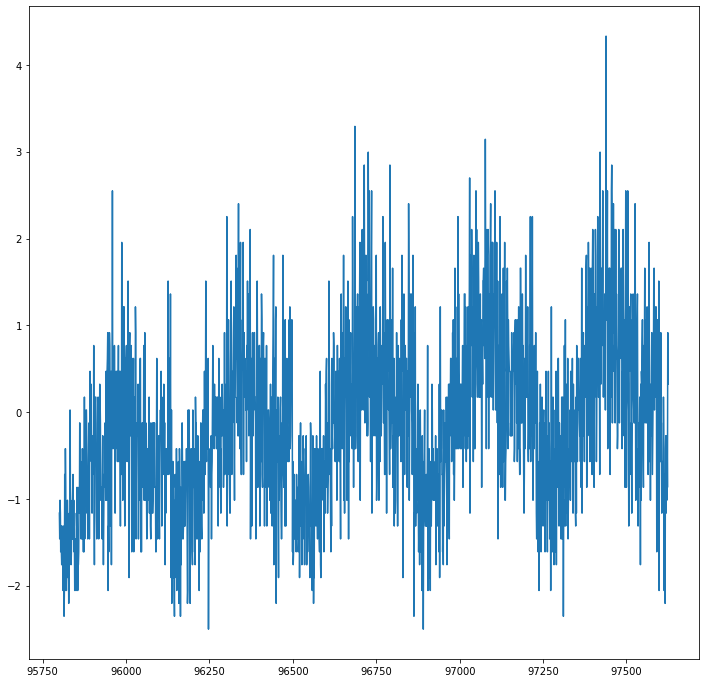

In [9]:
"""
Normalize data
"""
train["store_item_id"] = train["store"].astype(str) + "_" + train["item"].astype(str)
if mode == "valid":
    scale_data = train[train["date"] < "2017-01-01"]
else:
    scale_data = train[train["date"] >= "2014-01-01"]

# This step is very SLOW
scale_map = {}
scaled_data = pd.DataFrame()
for store_item_id, item_data in tqdm(data.groupby("store_item_id", as_index=False)):
    sidata = scale_data.loc[scale_data["store_item_id"] == store_item_id, "sales"]
    mu, sigma = sidata.mean(), sidata.std()
    yearly_autocorr = get_yearly_autocorr(sidata)

    item_data.loc[:, "sales"] = (item_data["sales"] - mu) / sigma  # normalize by mean and standard deviation
    scale_map[store_item_id] = {"mu": mu, "sigma": sigma}  # For future usage
    item_data["mean_sales"] = mu
    item_data["yearly_corr"] = yearly_autocorr
    scaled_data = pd.concat([scaled_data, item_data], ignore_index=True)

scaled_data["yearly_corr"] = (scaled_data["yearly_corr"] - scaled_data["yearly_corr"].mean()) / scaled_data[
    "yearly_corr"
].std()
scaled_data["mean_sales"] = (scaled_data["mean_sales"] - scaled_data["mean_sales"].mean()) / scaled_data[
    "mean_sales"
].std()

print("\nscaled_data.decribe():\n", scaled_data.describe())
print("\nscaled_data.head():\n", scaled_data.head())

# Plot out one store-item pair's sales number for illustration purposes
scaled_data.loc[scaled_data["store_item_id"] == "1_1", "sales"].plot()

In [10]:
scaled_data = reduce_mem_usage(scaled_data)
scaled_data.to_pickle("%s/processed_data_test_stdscaler.pkl" % DATA_FOLDER)

Memory usage decreased to 39.29 Mb (70.1% reduction)


In [14]:
# Due to a weird windows problem, multiprocessing cannot be run in notebook
# Then, pls run sequence_builder.py on scaled_data, and then load the pickle here
sequence_data = pd.read_pickle("%s/sequence_data_stdscaler_test.pkl" % DATA_FOLDER)
print("\nsequence_data.head()\n", sequence_data.head())


sequence_data.head()
   store_item_id  \
0          10_1   
1          10_1   
2          10_1   
3          10_1   
4          10_1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [12]:
class StoreItemDataset(Dataset):
    def __init__(
        self, cat_columns=[], num_columns=[], embed_vector_size=None, decoder_input=True, ohe_cat_columns=False
    ):
        super().__init__()

        self.sequence_data = None
        self.cat_columns = cat_columns
        self.num_columns = num_columns
        self.cat_classes = {}
        self.cat_embed_shape = []
        self.cat_embed_vector_size = embed_vector_size if embed_vector_size is not None else {}
        self.pass_decoder_input = decoder_input
        self.ohe_cat_columns = ohe_cat_columns
        self.cat_columns_to_decoder = False

    def get_embedding_shape(self):
        return self.cat_embed_shape

    def load_sequence_data(self, data):
        self.sequence_data = data

    def process_cat_columns(self, column_map=None):
        column_map = column_map if column_map is not None else {}
        for col in self.cat_columns:
            self.sequence_data[col] = self.sequence_data[col].astype("category")
            if col in column_map:
                self.sequence_data[col] = self.sequence_data[col].cat.set_categories(column_map[col]).fillna("#NA#")
            else:
                self.sequence_data[col].cat.add_categories("#NA#", inplace=True)
            self.cat_embed_shape.append(
                (len(self.sequence_data[col].cat.categories), self.cat_embed_vector_size.get(col, 50))
            )

    def __len__(self):
        return len(self.sequence_data)

    def __getitem__(self, idx):
        row = self.sequence_data.iloc[[idx]]
        x_inputs = [torch.tensor(row["x_sequence"].values[0], dtype=torch.float32)]
        y = torch.tensor(row["y_sequence"].values[0], dtype=torch.float32)

        if self.pass_decoder_input:
            decoder_input = torch.tensor(row["y_sequence"].values[0][:, 1:], dtype=torch.float32)

        if len(self.num_columns) > 0:
            for col in self.num_columns:
                num_tensor = torch.tensor([row[col].values[0]], dtype=torch.float32)
                x_inputs[0] = torch.cat((x_inputs[0], num_tensor.repeat(x_inputs[0].size(0)).unsqueeze(1)), axis=1)
                decoder_input = torch.cat(
                    (decoder_input, num_tensor.repeat(decoder_input.size(0)).unsqueeze(1)), axis=1
                )

        if len(self.cat_columns) > 0:
            if self.ohe_cat_columns:
                for ci, (num_classes, _) in enumerate(self.cat_embed_shape):
                    col_tensor = torch.zeros(num_classes, dtype=torch.float32)
                    col_tensor[row[self.cat_columns[ci]].cat.codes.values[0]] = 1.0
                    col_tensor_x = col_tensor.repeat(x_inputs[0].size(0), 1)
                    x_inputs[0] = torch.cat((x_inputs[0], col_tensor_x), axis=1)
                    if self.pass_decoder_input and self.cat_columns_to_decoder:
                        col_tensor_y = col_tensor.repeat(decoder_input.size(0), 1)
                        decoder_input = torch.cat((decoder_input, col_tensor_y), axis=1)
            else:
                cat_tensor = torch.tensor([row[col].cat.codes.values[0] for col in self.cat_columns], dtype=torch.long)
                x_inputs.append(cat_tensor)

        if self.pass_decoder_input:
            x_inputs.append(decoder_input)
            y = torch.tensor(row["y_sequence"].values[0][:, 0], dtype=torch.float32)

        if len(x_inputs) > 1:
            return tuple(x_inputs), y
        else:
            return x_inputs[0], y

In [13]:
"""
Validation scheme
Validation Model is trained on 2014 to 2016 data and predict 1st 3 months of 2017 data.

The best performing model will be trained on 2014 to 2017 data to predict first 3 months of 2018, without validation
In the validation model, sequences of the last 3 months of 2016 shouldn't be included because it contains 2017 values in y
"""

test_sequence_data = sequence_data[sequence_data["date"] == "2018-01-01"]

# data after 10th month will have prediction data in y_sequence
if mode == "test":
    train_sequence_data = sequence_data[
        (sequence_data["date"] <= "2017-10-01") & ((sequence_data["date"] >= "2014-01-02"))
    ]
    valid_sequence_data = pd.DataFrame()
else:
    train_sequence_data = sequence_data[
        (sequence_data["date"] <= "2016-10-01") & (sequence_data["date"] >= "2014-01-02")
    ]
    valid_sequence_data = sequence_data[
        (sequence_data["date"] > "2016-10-01") & (sequence_data["date"] <= "2017-01-01")
    ]

print(train_sequence_data.shape, valid_sequence_data.shape, test_sequence_data.shape)

train_dataset = StoreItemDataset(
    cat_columns=["store", "item"],
    num_columns=["yearly_corr"],
    embed_vector_size={"store": 4, "item": 4},
    ohe_cat_columns=True,
)
valid_dataset = StoreItemDataset(
    cat_columns=["store", "item"],
    num_columns=["yearly_corr"],
    embed_vector_size={"store": 4, "item": 4},
    ohe_cat_columns=True,
)
test_dataset = StoreItemDataset(
    cat_columns=["store", "item"],
    num_columns=["yearly_corr"],
    embed_vector_size={"store": 4, "item": 4},
    ohe_cat_columns=True,
)

train_dataset.load_sequence_data(train_sequence_data)
valid_dataset.load_sequence_data(valid_sequence_data)
test_dataset.load_sequence_data(test_sequence_data)

cat_map = train_dataset.process_cat_columns()
if mode == "valid":
    valid_dataset.process_cat_columns(cat_map)
test_dataset.process_cat_columns(cat_map)

batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(valid_dataloader))

(X_con, X_dec), y = next(iter(train_dataloader))
X_con.shape, y.shape, X_dec.shape

(684500, 7) (0, 0) (500, 7)
2674 0


(torch.Size([256, 180, 71]), torch.Size([256, 90]), torch.Size([256, 90, 9]))